In [82]:
import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch import nn

In [60]:
# before running make sure all your versions are the same as defined here

print('Pytorch:', torch.__version__)
print('Pytorch geometric:', torch_geometric.__version__)
print('Cuda available:', torch.cuda.is_available())

Pytorch: 2.1.1+cu118
Pytorch geometric: 2.4.0
Cuda available: True


In [68]:
# some important variables
SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [69]:
# read dataset
rating_df = pd.read_table('../data/raw/ml-100k/u.data', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

rating_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [70]:
# movies_df = pd.read_csv(
#     '../data/raw/ml-100k/u.item', 
#     header=None, 
#     encoding='latin-1', 
#     sep='|', 
#     names=[
#         'id', 'title', 'release_date', 'video_release_date', 'url', 
#         'unknown', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
#         'film_noir', 'Horror', 'Musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'
#     ],
#     index_col=0
# )

# movies_df.head()


# users_df = pd.read_csv(
#     '../data/raw/ml-100k/u.user', 
#     header=None, 
#     sep='|', 
#     names=[
#         'id', 'age', 'gender', 'occupation', 'zip_code'
#     ],
#     index_col=0
# )

# users_df.head()

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

TEST_SPLIT = 0.2


def split_dataset(df: pd.DataFrame, test_split: float = 0.2, seed: int = 0):
    # select only positive rating (>= 3)
    df = df[df['rating'] >= 3]

    # split dataset (& with a set seed of course)
    train, test = train_test_split(df.values, test_size=test_split, random_state=seed)
    train_df = pd.DataFrame(train, columns=df.columns)
    test_df = pd.DataFrame(test, columns=df.columns)
    
    # we splitted data, so ideally we need to relabel users 
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    
    # transform training dataset
    train_df['user_id_idx'] = user_encoder.fit_transform(train_df['user_id'].values)
    train_df['item_id_idx'] = item_encoder.fit_transform(train_df['item_id'].values)
    
    # remove all non-existing user-id's and item-id's from testing dataset
    train_user_ids = train_df['user_id'].unique()
    train_item_ids = train_df['item_id'].unique()
    
    test_df = test_df[(test_df['user_id'].isin(train_user_ids)) & (test_df['item_id'].isin(train_item_ids))]
    
    # transform test dataset
    test_df['user_id_idx'] = user_encoder.transform(test_df['user_id'].values)
    test_df['item_id_idx'] = item_encoder.transform(test_df['item_id'].values)
    
    return train_df, test_df


train_df, test_df = split_dataset(rating_df, seed=SEED)

In [75]:
def data_loader(data, batch_size, n_users, n_items):
    def sample_neg(x):
        while True:
            neg_id = np.random.randint(0, n_items - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    users = np.random.randint(0, n_users, batch_size)
    users.sort()
    
    users_df = pd.DataFrame(users, columns=['users'])  # may add .tolist()

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : np.random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_users, 
        torch.LongTensor(list(neg_items)).to(device) + n_users
    )


n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
data_loader(train_df, 16, n_users, n_items)

(tensor([ 76, 219, 255, 314, 392, 431, 565, 581, 601, 607, 630, 693, 740, 765,
         812, 916], device='cuda:0'),
 tensor([1188, 1273, 1311, 1125, 1877, 1123, 1566, 1200, 1199, 1454, 1249, 1119,
         1120, 1077, 1818, 1220], device='cuda:0'),
 tensor([1973, 2299, 1027, 1987, 2472, 2330, 2482, 2295, 1759, 2005, 2209, 1233,
         1313, 1039, 1921, 2146], device='cuda:0'))

In [80]:
def make_edge_index(df: pd.DataFrame):
    u_t = torch.LongTensor(df.user_id_idx)
    i_t = torch.LongTensor(df.item_id_idx) + n_users

    return torch.stack((
      torch.cat([u_t, i_t]),
      torch.cat([i_t, u_t])
    )).to(device)


train_edge_index = make_edge_index(train_df)
train_edge_index

tensor([[ 108,  435,  863,  ..., 1242, 1380, 1542],
        [1099, 1490, 1499,  ...,  811,  187,  298]], device='cuda:0')

# Because I am just curious, models

In [91]:
from torch_geometric.nn.conv import MessagePassing


class NGCFConv(MessagePassing):
    def __init__(self, latent_dim, dropout, bias=True, **kwargs):  
        super(NGCFConv, self).__init__(aggr='add', **kwargs)

        self.dropout = dropout

        self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
        self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

        self.init_parameters()


    def init_parameters(self):
        nn.init.xavier_uniform_(self.lin_1.weight)
        nn.init.xavier_uniform_(self.lin_2.weight)


    def forward(self, x, edge_index):
        # Compute normalization
        from_, to_ = edge_index
        deg = degree(to_, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages
        out = self.propagate(edge_index, x=(x, x), norm=norm)

        # Perform update after aggregation
        out += self.lin_1(x)
        out = F.dropout(out, self.dropout, self.training)
        return F.leaky_relu(out)


    def message(self, x_j, x_i, norm):
        return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

In [102]:
class RecSysGNN(nn.Module):
    def __init__(
        self,
        latent_dim, 
        num_layers,
        num_users,
        num_items,
        dropout=0.1
    ):
        super(RecSysGNN, self).__init__()

        self.embedding = nn.Embedding(num_users + num_items, latent_dim)
        self.convs = nn.ModuleList(NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers))
        self.init_parameters()


    def init_parameters(self):
        nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    

    def forward(self, edge_index):
        emb0 = self.embedding.weight
        embs = [emb0]

        emb = emb0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        out = torch.cat(embs, dim=-1) 
    
        return emb0, out


    def encode_minibatch(self, users, pos_items, neg_items, edge_index):
        emb0, out = self(edge_index)
        return (
            out[users], 
            out[pos_items], 
            out[neg_items], 
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )

In [103]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
    # compute loss from initial embeddings, used for regulization
    reg_loss = 0.5 * (user_emb0.norm().pow(2) + pos_emb0.norm().pow(2) + neg_emb0.norm().pow(2)) / float(len(users))

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss, reg_loss

In [104]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
    # compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    # create dense tensor of all user-item interactions
    i = torch.stack((
        torch.LongTensor(train_df['user_id_idx'].values),
        torch.LongTensor(train_df['item_id_idx'].values)
    ))
    v = torch.ones((len(train_df)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-item 
    # interactions
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

In [136]:
latent_dim = 128
n_layers = 4

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 3e-4
K = 20

In [137]:
def train_and_eval(model, optimizer, train_df):
    loss_list_epoch = []
    bpr_loss_list_epoch = []
    reg_loss_list_epoch = []

    recall_list = []
    precision_list = []

    for epoch in tqdm(range(EPOCHS)):
        n_batch = int(len(train)/BATCH_SIZE)
    
        final_loss_list = []
        bpr_loss_list = []
        reg_loss_list = []
    
        model.train()
        for batch_idx in range(n_batch):
            optimizer.zero_grad()

            users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
            users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

            bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
            )
            reg_loss = DECAY * reg_loss
            final_loss = bpr_loss + reg_loss

            final_loss.backward()
            optimizer.step()

            final_loss_list.append(final_loss.item())
            bpr_loss_list.append(bpr_loss.item())
            reg_loss_list.append(reg_loss.item())

        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall,  test_topK_precision = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K)

        loss_list_epoch.append(round(np.mean(final_loss_list),4))
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
        reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

        recall_list.append(round(test_topK_recall,4))
        precision_list.append(round(test_topK_precision,4))

    return (
        loss_list_epoch, 
        bpr_loss_list_epoch, 
        reg_loss_list_epoch, 
        recall_list, 
        precision_list
    )

In [138]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim, 
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2490, 128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128])]


In [139]:
from tqdm import tqdm
from torch_geometric.utils import degree
import torch.nn.functional as F
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:32<00:00,  6.65s/it]


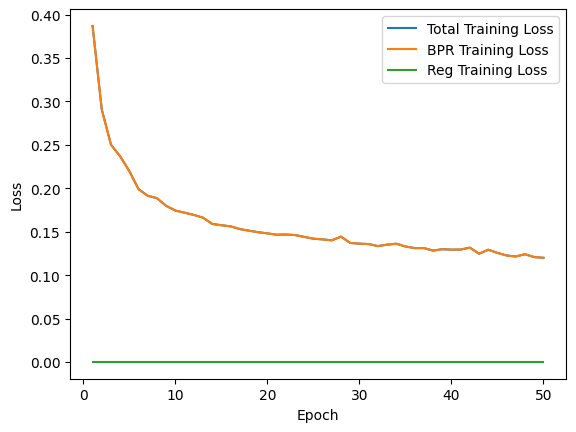

In [140]:
import matplotlib.pyplot as plt

epoch_list = [(i+1) for i in range(EPOCHS)]

plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

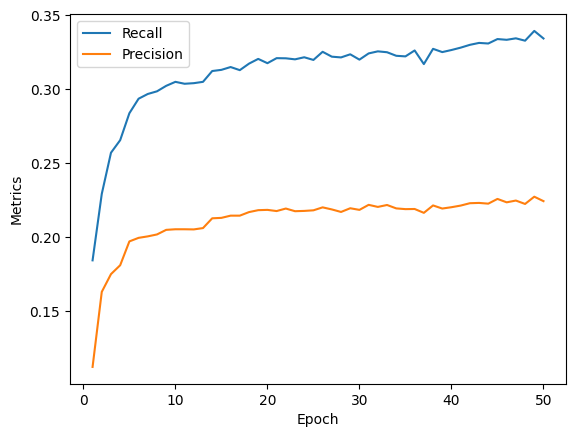

In [141]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [144]:
max(light_recall), max(light_precision)

(0.3394, 0.2274)